In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

textwidth = 455.24411 / 72 # inches
golden_ratio = (1 + 5**0.5) / 2
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['figure.figsize'] = (textwidth, textwidth / golden_ratio)
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = "Computer Modern Roman"
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['text.usetex'] = True

mpl.rcParams["figure.autolayout"] = True

import seaborn as sns

import gym
import numpy as np
np.random.seed(42)
import pandas as pd
from gym.wrappers import TimeLimit
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env

# from src.custom_cnn import CustomCNN
from src.custom_policy import CustomActorCriticPolicy, ReshapeExtractor


In [3]:
J = 1.0
env_id = "gym_xymodel:ising2d-v0"



Use only one from the cells below:

In [66]:
SIDE_LENGTH = 4
env = gym.make(
    env_id,
    L=SIDE_LENGTH,
    J=J,
)
IS_CNN = False
IS_CONTINUOUS = False

folder_path = "../results/ising2D/L4/2022-12-29T132118_mlp_nenvs8"

model = PPO.load(folder_path + "/model", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [27]:
SIDE_LENGTH = 6
env = gym.make(
    env_id,
    L=SIDE_LENGTH,
    J=J,
)
IS_CNN = False
IS_CONTINUOUS = False

folder_path = "../results/medusa/ising_L6/2022-12-31T130553_mlp_nenvs8_nfeat128"
model = PPO.load(folder_path + "/model", env=env)

In [36]:
SIDE_LENGTH = 6
env = gym.make(
    env_id,
    L=SIDE_LENGTH,
    J=J,
)
IS_CNN = True
IS_CONTINUOUS = False

folder_path = "../results/results_medusa/ising2D/L6/2023-01-09T021320_cstmpol_nfilters64_nblocks3"
model = PPO.load(folder_path + "/model", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [72]:
# Ising 2D 2nd neighbor
SIDE_LENGTH = 4
env = gym.make("gym_xymodel:ising2d_2ndneighbor-v0", L=SIDE_LENGTH, J1=-1.0, J2=-1.0)
folder_path = "../results/results_medusa/ising2D_2ndNN/L4/2023-01-08T192052_mlp_nfeat128"
model = PPO.load(folder_path + "/model", env=env)

    

In [73]:
MAX_EPISODE_STEPS = 2 * SIDE_LENGTH**2
DETERMINISTIC = True

all_energies = [] # list of lists
for i in range(100):
    energies = []
    obs = env.reset()
    lattice_init = env.state_to_lattice()
    energies.append(env.compute_energy())
    for i in range(MAX_EPISODE_STEPS):
        action, _state = model.predict(obs, deterministic=DETERMINISTIC)
        obs, reward, done, info = env.step(action)
        energies.append(env.compute_energy())
        if done:
            # print(f"{reward=}")
            break
            # env.reset()
        # if i % 100 == 0:
        #   print(f"{i=}, {reward=}")
        #   env.render()
    all_energies.append(energies)


In [74]:
if DETERMINISTIC:
    all_energies_det = all_energies

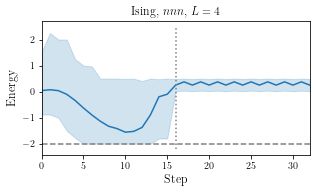

In [76]:
# df = pd.DataFrame(all_energies).melt()
df_det = pd.DataFrame(all_energies_det).melt(ignore_index=False).reset_index()
df = pd.DataFrame(all_energies).melt(ignore_index=False).reset_index()

# fig, ax = plt.subplots(figsize=(0.45 * textwidth * golden_ratio, 0.45 * textwidth))
fig, ax = plt.subplots(figsize=(0.44 * textwidth * golden_ratio, 0.44 * textwidth))
# sns.lineplot(ax=ax, x="variable", y="value", data=df_det, hue="index",  palette="Purples", alpha=0.5, label=None, legend=False)
# sns.lineplot(ax=ax, x="variable", y="value", data=df, hue="index",  palette="Greens", alpha=0.5, label=None, legend=False)
sns.lineplot(ax=ax, x="variable", y="value", data=df_det, errorbar=("pi", 95), label="deterministic") #, ci="sd")
# sns.lineplot(ax=ax, x="variable", y="value", data=df, errorbar=("pi", 95), label="stochastic", color="orange") #, ci="sd")
# sns.scatterplot(ax=ax, x="variable", y="value", data=df, hue="index",  palette="autumn", alpha=0.5, legend=False)

# plt.xlim(0, MAX_EPISODE_STEPS)
# plt.hlines(-2.0, 0, MAX_EPISODE_STEPS, linestyles="dashed", colors="gray")
plt.vlines(SIDE_LENGTH**2, *ax.get_ylim(), linestyles="dotted", colors="gray")
plt.xlim(0, df.variable.max())
plt.hlines(-2.0, 0, df.variable.max(), linestyles="dashed", colors="gray")
plt.xlabel("Step")
plt.ylabel("Energy")
plt.tight_layout()
# plt.title(f"Ising, $L={SIDE_LENGTH}$")
plt.title(f"Ising, $nnn$, $L={SIDE_LENGTH}$")
# plt.legend()
plt.legend().remove()

E_lims = ax.get_ylim()

# path = f"../results/ising_L{SIDE_LENGTH}"
path = f"../results/isingNNN_L{SIDE_LENGTH}"
path += "_energy"
if not DETERMINISTIC:
    path += "_stochastic"
if IS_CNN:
    path += "_cnn"
if IS_CONTINUOUS:
    path += "_continuous"
plt.savefig(path + ".pdf")
# plt.savefig(path + "_full.pdf")


array([ 0,  0,  0,  1,  0,  3,  9, 12, 19, 13, 15, 12,  7,  4,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4])

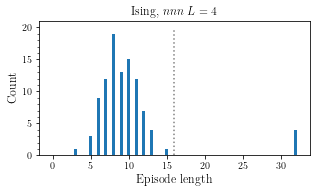

In [78]:
MAX_EPISODE_STEPS = df.variable.max()

step_amount_det = np.array([df_det[df_det["variable"]==i].count()['value'] for i in range(MAX_EPISODE_STEPS+2)])
step_amount = np.array([df[df["variable"]==i].count()['value'] for i in range(MAX_EPISODE_STEPS+2)])
aend_hist_det = -np.diff(step_amount_det)
aend_hist = -np.diff(step_amount)
# sns.barplot(x=np.arange(15), y=aend_hist)
fig, ax = plt.subplots(figsize=(0.44 * textwidth * golden_ratio, 0.44 * textwidth))

ax.bar(x=np.arange(df.variable.max()+1), height=aend_hist_det, width=0.4)

# ax.bar(x=np.arange(MAX_EPISODE_STEPS+1)-0.2, height=aend_hist_det, width=0.4)
# ax.bar(x=np.arange(MAX_EPISODE_STEPS+1)+0.2, height=aend_hist,color="orange", width=0.4)
# plt.xlim(0,MAX_EPISODE_STEPS+1)
plt.vlines(SIDE_LENGTH**2, *ax.get_ylim(), linestyles="dotted", colors="gray")
plt.xlabel("Episode length")
plt.ylabel("Count")


ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# plt.title(f"Ising, $L={SIDE_LENGTH}$")
plt.title(f"Ising, $nnn$ $L={SIDE_LENGTH}$")

# path = f"../results/ising_L{SIDE_LENGTH}"
path = f"../results/isingNNN_L{SIDE_LENGTH}"
path += "_eplength"
if not DETERMINISTIC:
    path += "_stochastic"
if IS_CNN:	
    path += "_cnn"
if IS_CONTINUOUS:
    path += "_continuous"
plt.savefig(path + ".pdf")

# sns.histplot(df.dropna(), x="variable")
aend_hist

[96, 1, 2, 1]

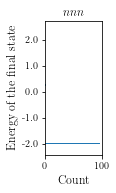

In [83]:
fig, ax = plt.subplots(figsize=(0.44 * textwidth / golden_ratio, 0.44 * textwidth))


last_energies_det = [energies[-1] for energies in all_energies_det]
last_energies = [energies[-1] for energies in all_energies]
possible_energies_det = np.unique(last_energies_det)
possible_energies = np.unique(last_energies)
last_energies_counts_det = [last_energies_det.count(pE) for pE in possible_energies_det]
last_energies_counts = [last_energies.count(pE) for pE in possible_energies]

height = 0.05
ax.barh(possible_energies_det, last_energies_counts_det, align='center', height=height)
# ax.barh(possible_energies_det+(height/2), last_energies_counts_det, align='center', height=height)
# ax.barh(possible_energies-(height/2), last_energies_counts, align='center', height=height, color="orange")

# plt.yticks(np.unique([energies[-1] for energies in all_energies]))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.1f}"))
plt.ylim(E_lims)

# plt.xticks([0] + last_energies_counts)


plt.xlabel("Count")
plt.ylabel("Energy of the final state")
# plt.title("MLP")
# plt.title("CNN")
plt.title("$nnn$")

# path = f"../results/ising_L{SIDE_LENGTH}"
path = f"../results/isingNNN_L{SIDE_LENGTH}"
path += "_efinalcount"
if not DETERMINISTIC:
    path += "_stochastic"
if IS_CNN:
    path += "_cnn"
if IS_CONTINUOUS:
    path += "_continuous"
plt.savefig(path + ".pdf")

last_energies_counts_det

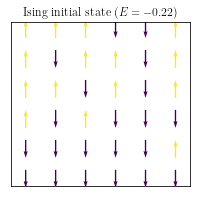

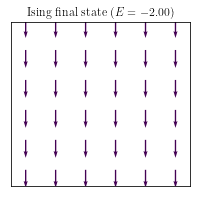

In [38]:
def plot_lattice(lattice):
    # ax = plt.figure().add_subplot()
    fig, ax = plt.subplots(figsize=(0.45*textwidth,0.45*textwidth))
    x, y = np.meshgrid(np.arange(SIDE_LENGTH),
                np.arange(SIDE_LENGTH))
    ax.quiver(x, y, np.zeros_like(lattice), lattice, lattice,  pivot='mid', scale=10)
    ax.axis('equal')
    ax.set(xlim=(-0.5, SIDE_LENGTH - 0.5), ylim=(-0.5, SIDE_LENGTH - 0.5))
    plt.xticks([])
    plt.yticks([])
    return fig, ax

fig, ax = plot_lattice(lattice_init)
ax.set_title(f"Ising initial state $(E={all_energies[-1][0]:.2f})$")
fig.tight_layout()
# plt.savefig(f"../results/ising_L{SIDE_LENGTH}_initial_state.png", dpi=600)
plt.savefig(f"../results/ising_L{SIDE_LENGTH}_initial_state.pdf")
# plt.savefig(f"../results/isingNNN_L{SIDE_LENGTH}_initial_state.pdf")


fig, ax = plot_lattice(env.state_to_lattice())
ax.set_title(f"Ising final state  $(E={all_energies[-1][-1]:.2f})$")
fig.tight_layout()
# plt.savefig(f"../results/ising_L{SIDE_LENGTH}_final_state.png", dpi=600)
plt.savefig(f"../results/ising_L{SIDE_LENGTH}_final_state.pdf")
# plt.savefig(f"../results/isingNNN_L{SIDE_LENGTH}_final_state.pdf")



plt.show()

